<a href="https://colab.research.google.com/github/spencerklawans/466-Project/blob/main/WildfirePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wildfire Prediction
Brought to you by Gooogle Earth Engine

In [ ]:
# Import libraries.
import ee
import folium

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = "Map Data © Google Earth Engine",
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [41]:
#Init KDD libraries

%matplotlib inline

import numpy as np
import pandas as pd
import sklearn
import time
import matplotlib.pyplot as plt

In [32]:
California = ee.Geometry.Rectangle(-124.18, 41.39, -114.35, 32.75)
earliestDataStart = '2014-09-01T00:00:00'
# Import our fire events as features
modis_fires = ee.FeatureCollection('JRC/GWIS/GlobFire/v2/FinalPerimeters').filterBounds(California).filter(ee.Filter.gte('InitialDate', ee.Date.millis(earliestDataStart)))
# filter for only fires with greater than 10,000,000 square meters
modis_fires = modis_fires.filter(ee.Filter.gt('area', 10000000)).randomColumn(seed=0)

# Add a band for if this is a really big fire or not. 
# NOTE: We are using fire size as a proxy for severity
massive_fire_threshold = 100000000
massive_fires = modis_fires.filter(ee.Filter.gt('area', massive_fire_threshold)).limit(10, 'random').map(lambda f: f.set({'massive': 1}))  # 158 fires
other_fires = modis_fires.filter(ee.Filter.lte('area', massive_fire_threshold)).limit(10, 'random').map(lambda f: f.set({'massive': 0}))   # 609 fires

# split the fires into a test and training set
massive_fires_test = massive_fires.limit(3, 'random', False)
massive_fires_train = massive_fires.limit(7, 'random', True)
other_fires_test = other_fires.limit(3, 'random', False)
other_fires_train = other_fires.limit(7, 'random', True)

modis_fires_train = massive_fires_train.merge(other_fires_train)
modis_fires_test = massive_fires_test.merge(other_fires_test)
modis_fires = modis_fires_train.merge(modis_fires_test)

In [22]:
print("massive", modis_fires.filter(ee.Filter.eq('massive', 1)).size().getInfo())
print("small", modis_fires.filter(ee.Filter.eq('massive', 0)).size().getInfo())

massive 14
small 14


In [33]:
slo = ee.Geometry.Point([-120.4358, 35.3102])

# Import ImageCollections
landfire_prs = ee.Image("LANDFIRE/Fire/PRS/v1_2_0/CONUS")
landfire_evc = ee.Image("LANDFIRE/Vegetation/EVC/v1_4_0/CONUS")
landfire_evh = ee.Image("LANDFIRE/Vegetation/EVH/v1_4_0/CONUS")
landfire_evt = ee.Image("LANDFIRE/Vegetation/EVT/v1_4_0/CONUS")
daily_temp = ee.ImageCollection("ECMWF/ERA5/DAILY").filterDate(earliestDataStart, '2021-01-01')

fire_image2 = modis_fires.reduceToImage(
    properties = ['InitialDate'], 
    reducer = ee.Reducer.first()).rename('InitialDate')

composite = landfire_evc.addBands(landfire_prs).addBands(landfire_evh).addBands(landfire_evt).addBands(fire_image2)

In [34]:
bands = ['PRS', 'EVC','EVH','EVT','mean_temp', 'wind_speed']
# split the data into training and test sets
fire_image = ee.Image().byte().paint(modis_fires, 'massive').rename('massive')

fire_points_train = fire_image.addBands(ee.Image.pixelLonLat()).stratifiedSample(
                                                              numPoints=200,
                                                              classBand='massive',
                                                              scale=30,
                                                              region=modis_fires_train.geometry()).map(
                                                                  lambda f: f.setGeometry(ee.Geometry.Point([f.get('longitude'), f.get('latitude')])))
                                                              
fire_points_test = fire_image.addBands(ee.Image.pixelLonLat()).stratifiedSample(
                                                              numPoints=50,
                                                              classBand='massive',
                                                              scale=30,
                                                              region=modis_fires_test.geometry()).map(
                                                                  lambda f: f.setGeometry(ee.Geometry.Point([f.get('longitude'), f.get('latitude')])))

                                                              



data = composite.sampleRegions(fire_points_train, properties=['massive'], scale=30, geometries=True)
data_test = composite.sampleRegions(fire_points_test, properties=['massive'], scale=30, geometries=True)


def getTempForDate(feature):
  initial_date = feature.get('InitialDate')
  date_filter = ee.Filter.lte('system:time_start', initial_date)
  tempImage = daily_temp.filter(date_filter).limit(1, 'system:time_start', False).first()
  tempImageSample = tempImage.sample(feature.geometry()).first()
  u_wind = ee.Number(tempImageSample.get('u_component_of_wind_10m'))
  v_wind = ee.Number(tempImageSample.get('u_component_of_wind_10m'))
  return feature.set({
      "mean_temp": tempImageSample.get('mean_2m_air_temperature'),
      "wind_speed": (u_wind.pow(2).add(v_wind.pow(2))).sqrt(),
      "date_offset": ee.Number(initial_date).subtract(tempImage.get('system:time_start'))
      })


five_days_millis = 432000000
# Get most recent temp data within the past 5 days 
data = data.map(getTempForDate).filter(ee.Filter.lte('date_offset', five_days_millis))
data_test = data_test.map(getTempForDate).filter(ee.Filter.lte('date_offset', five_days_millis))

In [ ]:
print("massive", fire_points_train.filter(ee.Filter.eq('massive', 1)).size().getInfo())
print("small", fire_points_train.filter(ee.Filter.eq('massive', 0)).size().getInfo())

massive 200
small 200


In [30]:
n_train = 0.6
n_val = 0.5
temp = data.filter(ee.Filter.lt('random', 1-n_train))
training = data.filter(ee.Filter.gte('random', 1-n_train))
validation = temp.filter(ee.Filter.lt('random', (1-n_train)*n_val))
testing = temp.filter(ee.Filter.gte('random', (1-n_train)*n_val))

In [9]:
#small_points = composite.sampleRegions(other_fires, geometries=True)
classifier = ee.Classifier.smileRandomForest(100).train(features=data, classProperty='massive', inputProperties=bands)
pred = data_test.classify(classifier)

In [10]:
accuracy = pred.errorMatrix('massive', 'classification')
print(accuracy.getInfo())


[[49, 1], [32, 18]]


In [ ]:
data.first().getInfo()

In [40]:
accuracies = {}
importances = {}
for n_trees in [10, 50, 100, 150, 300]:
  classifier = ee.Classifier.smileRandomForest(n_trees, maxNodes=3).train(features=data, classProperty='massive', inputProperties=bands)
  pred = data_test.classify(classifier)
  # print(pred.errorMatrix('massive', 'classification').getInfo())
  # print(classifier.explain().getInfo())
  importances[n_trees] = classifier.explain().getInfo()['importance']
  accuracies[n_trees] = pred.errorMatrix('massive', 'classification').accuracy().getInfo()

importances

{10: {'EVC': 0,
  'EVH': 0.09820491352753963,
  'EVT': 0.10453234171346235,
  'PRS': 0.664665059763864,
  'mean_temp': 1.5001365185873166,
  'wind_speed': 0.8801275976310734},
 50: {'EVC': 0.05587848764210723,
  'EVH': 0.9399936492023097,
  'EVT': 0.12513388196701788,
  'PRS': 2.1408585108805354,
  'mean_temp': 5.910780642427078,
  'wind_speed': 6.405630570551798},
 100: {'EVC': 0.12796169914383232,
  'EVH': 1.3757149796679293,
  'EVT': 0.5070584180255019,
  'PRS': 4.246835885821979,
  'mean_temp': 12.591717258017155,
  'wind_speed': 12.972651105428907},
 150: {'EVC': 0.16455741194760914,
  'EVH': 2.5331906043307364,
  'EVT': 0.7390129482039207,
  'PRS': 6.037624149418604,
  'mean_temp': 18.215467953881802,
  'wind_speed': 18.402336127475486},
 300: {'EVC': 0.5396529702625095,
  'EVH': 4.648168359064384,
  'EVT': 1.1001874658941735,
  'PRS': 13.283792960623636,
  'mean_temp': 34.874384975778824,
  'wind_speed': 35.394789860995544}}

Text(0, 0.5, 'accuracy')

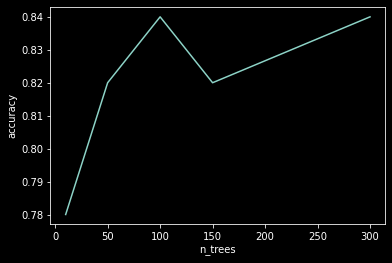

In [50]:
plt.style.use('dark_background')
plt.plot([x for x in accuracies.keys()], [x for x in accuracies.values()])
plt.xlabel('n_trees')
plt.ylabel('accuracy')


In [52]:
classifier = ee.Classifier.smileRandomForest(100, maxNodes=3).train(features=data, classProperty='massive', inputProperties=bands)
pred = data_test.classify(classifier)
pred.errorMatrix('massive', 'classification').getInfo()

[[47, 3], [13, 37]]

In [12]:
gb_classifier = ee.Classifier.smileGradientTreeBoost(100).train(features=data, classProperty='massive', inputProperties=bands)
gb_pred = data_test.classify(gb_classifier)
gb_pred.errorMatrix('massive', 'classification').getInfo()

[[43, 7], [34, 16]]

In [13]:
gb_classifier.explain().getInfo()

{'classes': [0, 1],
 'importance': {'EVC': 18678.738123745836,
  'EVH': 3246.3134386042825,
  'EVT': 14428.47739336925,
  'PRS': 11712.675790837366,
  'mean_temp': 18963.455669348656,
  'wind_speed': 17154.66335587012},
 'numberOfTrees': 100,
 'trees': ['digraph RegressionTree {\n node [shape=box, style="filled, rounded", color="black", fontname=helvetica];\n edge [fontname=helvetica];\n 0 [label=<wind_speed &le; 1.9644<br/>score = 106.3395>, fillcolor="#00000000"];\n 1 [label=<mean_temp &le; 288.9657<br/>score = 87.8422>, fillcolor="#00000000"];\n 0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"];\n 2 [label=<PRS &le; 2.5000<br/>score = 64.2861>, fillcolor="#00000000"];\n 0 -> 2 [labeldistance=2.5, labelangle=-45, headlabel="False"];\n 3 [label=<EVC &le; 112.5000<br/>score = 14.3618>, fillcolor="#00000000"];\n 1 -> 3;\n 4 [label=<wind_speed &le; 0.2706<br/>score = 129.0767>, fillcolor="#00000000"];\n 1 -> 4;\n 5 [label=<EVC &le; 102.5000<br/>score = 24.6202>, fillcolor="#000

In [11]:
# pred.errorMatrix('massive', 'classification').accuracy().getInfo()
classifier.explain().getInfo()

{'classes': [0, 1],
 'importance': {'EVC': 13.689297344823537,
  'EVH': 10.990965562998518,
  'EVT': 20.255108520611113,
  'PRS': 24.787762140506192,
  'mean_temp': 70.010267036039,
  'wind_speed': 77.83880510088771},
 'numberOfTrees': 100,
 'outOfBagErrorEstimate': 0.008797653958944282,
 'trees': ['n= 171\nnode), split, n, loss, yval, (yprob)\n* denotes terminal node\n1) root 171 83.041 0 (0.58382 0.41618)\n 2) mean_temp<=293.132 107 32.523 0 (0.80734 0.19266)\n  4) PRS<=1.50000 18 0.0000 1 (0.050000 0.95000) *\n  5) PRS>1.50000 89 3.9101 0 (0.96703 0.032967)\n   10) EVC<=105.500 58 1.9655 0 (0.96667 0.033333)\n    20) mean_temp<=290.358 5 1.6000 0 (0.71429 0.28571)\n     40) EVC<=103.500 4 0.0000 0 (0.83333 0.16667) *\n     41) EVC>103.500 1 0.0000 1 (0.33333 0.66667) *\n    21) mean_temp>290.358 53 0.0000 0 (0.98182 0.018182) *\n   11) EVC>105.500 31 1.9355 0 (0.93939 0.060606)\n    22) PRS<=14.5000 7 1.7143 0 (0.77778 0.22222)\n     44) EVH<=110.500 6 0.0000 0 (0.87500 0.12500) *\n

In [53]:
# Set visualization parameters. I'm pretty sure min and max should track to the min and max values of the set at https://developers.google.com/earth-engine/datasets/catalog/LANDFIRE_Fire_PRS_v1_2_0#bands
prs_viz_params = {
    'bands': ['PRS']
}

evc_vis_params = {
    'bands': ['EVC'],
    'opacity': 0.5
}
fires_viz_params = {
    'bands': ['massive'],
    'palette': ['#FF0000', '#0000FF'],
     'min': 0,
     'max': 1,
     'opacity': 0.5
}
pred_viz_params = {
    'palette': ['#FF0000', '#0000FF'],
    'min': 0,
    'max': 1,
    'opacity': 0.5
}

# Create a folium map object.
my_map = folium.Map(location=[35.3102, -120.4358], zoom_start=8)

# Add the fire severity & existing vegetation type images to the map object.
my_map.add_ee_layer(landfire_prs, prs_viz_params, 'Percent Replacement-Severity Fire')
my_map.add_ee_layer(landfire_evc, evc_vis_params, 'Existing Vegetation Cover')
my_map.add_ee_layer(fire_image, fires_viz_params, 'Fire Events')
my_map.add_ee_layer(ee.Image().paint(pred, 'classification'), pred_viz_params, 'Predicted Events')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)